In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt

In [2]:
%cd /content/drive/MyDrive/MNIST/

/content/drive/MyDrive/MNIST


In [42]:
batch_size = 128
epochs = 10
lr = 0.001

In [33]:
# Define transform
transform = transforms.Compose([
    transforms.ToTensor()
])

In [34]:
# Split dataset
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST('./data', train=False, download=True, transform=transform)
val_dataset, test_dataset = torch.utils.data.random_split(test_dataset, [int(0.9*len(test_dataset)), len(test_dataset)-int(0.9*len(test_dataset))])

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 519kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.51MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.88MB/s]


In [35]:
# Setup dataloader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [36]:
print(f"Train: {len(train_dataset)}")
print(f"Val: {len(val_dataset)}")
print(f"Test: {len(test_dataset)}")

Train: 60000
Val: 9000
Test: 1000


In [37]:
# Define model
class ConvNet(nn.Module):
  def __init__(self):
    super(ConvNet, self).__init__()
    self.layer1 = nn.Sequential(
        nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.layer2 = nn.Sequential(
        nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(64*7*7, 128)
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(0.5)
    self.fc2 = nn.Linear(128, 10)
  def forward(self, x):
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.flatten(x)
    x = self.fc1(x)
    x = self.relu(x)
    x = self.dropout(x)
    x = self.fc2(x)
    return x

In [38]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [39]:
# Model, loss function, optimizer
model = ConvNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

Training and validate


In [43]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
best_val_loss = 1

for epoch in range(epochs):
  # Train
  train_loss = 0.0
  correct = 0
  total = 0
  model.train()
  for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)

    optimizer.zero_grad()
    pred = model(images)
    loss = criterion(pred, labels)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    _, predicted = torch.max(pred.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  train_loss = train_loss / len(train_loader)
  train_acc = 100 * correct/total
  train_losses.append(train_loss)
  train_accuracies.append(train_acc)

  # Validation
  model.eval()
  val_loss = 0.0
  correct = 0
  total = 0
  with torch.no_grad():
    for i, (images, labels) in enumerate(val_loader):
      images, labels = images.to(device), labels.to(device)

      pred = model(images)
      loss = criterion(pred, labels)
      val_loss += loss.item()
      _, predicted = torch.max(pred.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  val_loss = val_loss / len(val_loader)
  val_acc = 100 * correct / total
  val_losses.append(val_loss)
  val_accuracies.append(val_acc)

  print(f'Epoch [{epoch+1}/{epochs}] | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}')

  if val_loss < best_val_loss:
    best_val_loss = val_loss
    torch.save(model.state_dict(), 'best_model.pth')

Epoch [1/10] | Train Loss: 0.1298 | Train Acc: 96.14 | Val Loss: 0.0465 | Val Acc: 98.46
Epoch [2/10] | Train Loss: 0.0846 | Train Acc: 97.54 | Val Loss: 0.0378 | Val Acc: 98.69
Epoch [3/10] | Train Loss: 0.0668 | Train Acc: 97.96 | Val Loss: 0.0371 | Val Acc: 98.70
Epoch [4/10] | Train Loss: 0.0570 | Train Acc: 98.33 | Val Loss: 0.0301 | Val Acc: 99.01
Epoch [5/10] | Train Loss: 0.0490 | Train Acc: 98.58 | Val Loss: 0.0306 | Val Acc: 98.91
Epoch [6/10] | Train Loss: 0.0430 | Train Acc: 98.69 | Val Loss: 0.0270 | Val Acc: 99.18
Epoch [7/10] | Train Loss: 0.0368 | Train Acc: 98.86 | Val Loss: 0.0273 | Val Acc: 99.08
Epoch [8/10] | Train Loss: 0.0354 | Train Acc: 98.91 | Val Loss: 0.0252 | Val Acc: 99.17
Epoch [9/10] | Train Loss: 0.0312 | Train Acc: 99.05 | Val Loss: 0.0256 | Val Acc: 99.22
Epoch [10/10] | Train Loss: 0.0286 | Train Acc: 99.08 | Val Loss: 0.0301 | Val Acc: 99.14


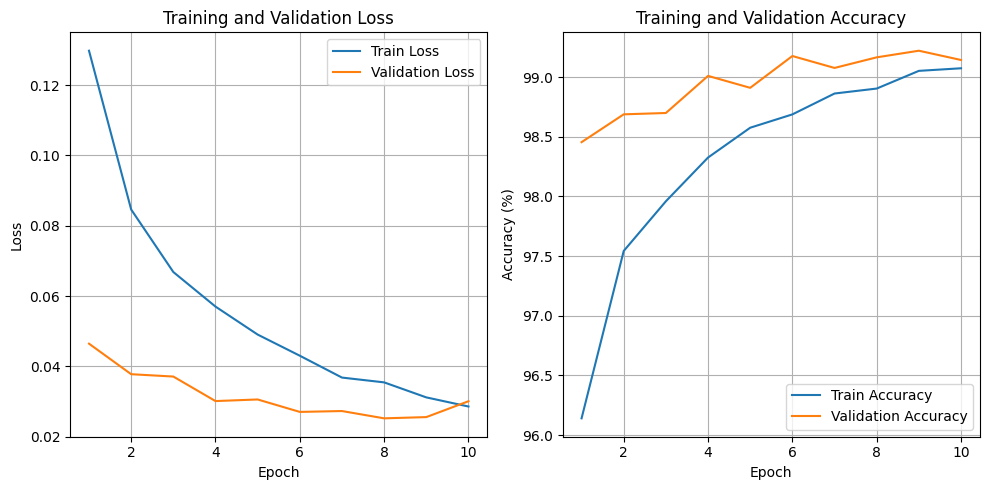

In [44]:
# Loss plot
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('mnist_training_plots.png')

In [46]:
#Test model
model.load_state_dict(torch.load('best_model.pth'))
model.eval()
correct = 0
total = 0
with torch.no_grad():
  for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    pred = model(images)
    _, predicted = torch.max(pred.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
test_acc = 100 * correct / total
print(f'Test Accuracy: {test_acc}')

Test Accuracy: 99.5
